#  Прогнозирование заказов такси

Компания «Такси» собрала данные о заказах такси в аэропорте. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель исследования** 

Необходимо построить модель для предсказания количества заказов такси на следующий час.

**Ход исследования**

В нашем распоряжении архив заказов такси. Прежде чем приступить к построению модели, подготовим данные для обучения.

Таким образом, исследование пройдёт в четыре этапа:
1. Подготовить данные;
2. Проанализировать данные;
3. Построить и обучить модели;
4. Выполнить анализ моделей.

Примечания:
- Для оценки качества моделей применим метрику RMSE.
- Значение метрики RMSE должно быть не больше 48.

## Подготовка

### Открытие файлов. Общее предоставление

Импортируем библиотеки для работы в Питоне.

In [1]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

Откроем файл с данными и изучим общую информацию. Прочитаем файл и сохраним его в датасет. Для того, чтобы корректно работать с датой и временем в pandas, нужно
корректно изменить тип данных соответствующего столбца с object на
datetime64. Один из вариантов — сделать это прямо при чтении с
помощью параметра parse_dates. Также, необходимо установить индекс
датафрейма, указав в параметре index_col.

In [4]:
try: 
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except: 
    taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Мы открыли данные, приняв дату за индекс (тип данных Datetime). В архиве имеется 26496 записей с марта по август 2018 года.

Согласно документации к данным:

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

### Временные ряды

Проверим хронологический порядок расположения даты и время. Для этого
нужно посмотреть атрибут индекса таблицы is_monotonic. Если порядок
соблюдён, атрибут вернёт True.

In [6]:
# checking of monotonic data
taxi.index.is_monotonic

True

Построим график временного ряда для исходных данных.

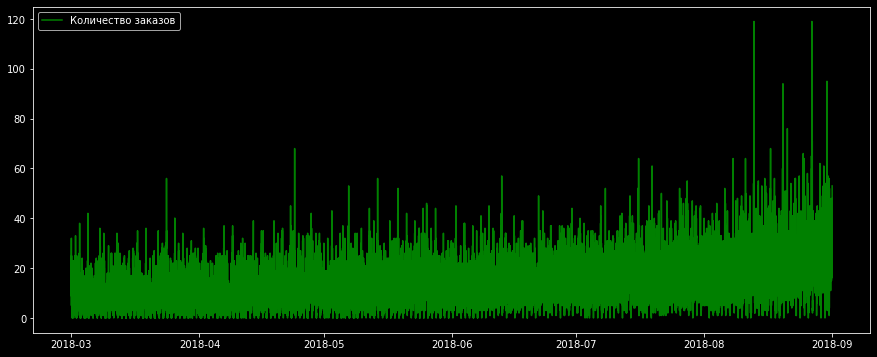

In [7]:
plt.style.use('dark_background')
figsize = (15, 6)

# function for plot
def plot_figure(data):
    plt.figure(figsize=figsize)
    plt.plot(data, 'g', label='Количество заказов')
    plt.legend()

# plot of data
plot_figure(taxi)

График трудно проанализировать. Данные содержат записи о заказах каждых 10 минут. Необходимо поменять интервал временного ряда. Выполним его ресемплирование по одному часу — изменение интервала со значениями ряда. Вызовем функции resample() с sum() для агрегации значений (суммарное количество заказов).

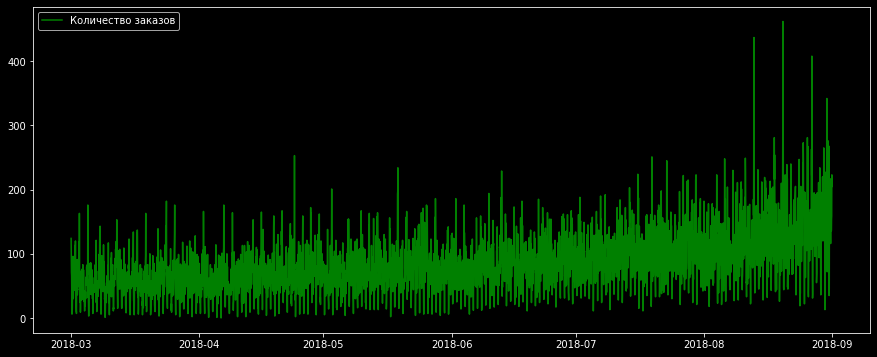

In [8]:
# data resample
taxi_resample = taxi.resample('1H').sum()

# plot of data
plot_figure(taxi_resample)

График немного прояснился.

### Вывод

В архиве имеется 26496 записей с марта по август 2018 года, интервал записей - 10 минут. Была выполнена подготовка данных:
* Открыли данные, приняв дату за индекс (тип данных Datetime). 
* Проверка на монотонность. Даты и время расположены в хронологическом порядке.
* Выполнено ресемплирование по одному часу.

## Анализ

### Скользящее среднее

Скользящее среднее (англ. rolling mean), или движущееся среднее (англ.
moving average), — метод сглаживания временных рядов. Его суть
заключается в поиске значений, которые меньше всего подвержены
колебаниям. Вызовом функции rolling() создадим скользящее окно. В аргументе
укажем 24 часа - один день.

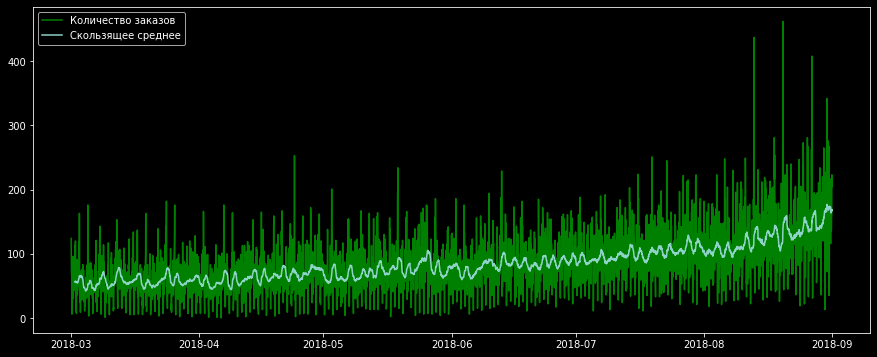

In [9]:
# function of rolling mean
def plot_roll(data):
    plot_figure(data)
    plt.plot(data.rolling(24).mean(), label='Скользящее среднее')
    plt.legend();

# plot of rolling mean
plot_roll(taxi_resample)

Средние значения по заказам распределены волнообразно. 

### Заказы за день

Возьмем интервал в 1 день в мае и посмотрим на данные.

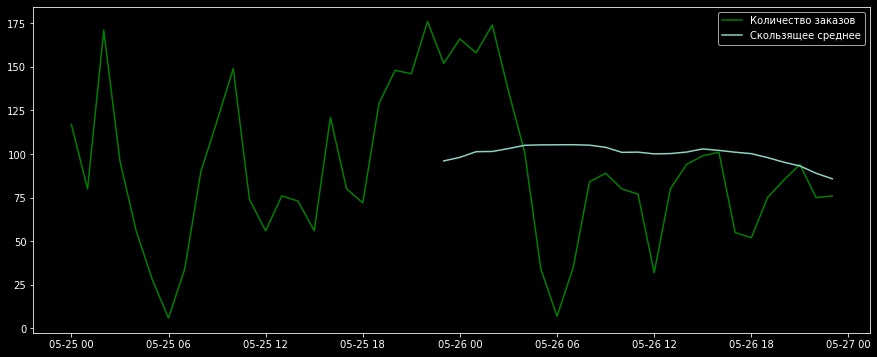

In [10]:
# period within 1 day
taxi_day = taxi_resample['2018-05-25':'2018-05-26']

# plot of rolling mean
plot_roll(taxi_day)

Отметим закономерность в течение дня: 
* Число заказов максимально ближе к полуночи до часа ночи. Вероятные причины - большое количество дешевых авиарейсов ночью.
* Резкое снижение до 6 утра. Вероятные причины - малое количество авиарейсов.
* Значительное увеличение заказов после 6 утра. Вероятные причины - большое количество сравнительно недорогих авиарейсов, вылеты клиентов по работе.
* Остальные заказы в течение дня колеблются в пределах некоторой величины. Средние значения почти не меняются.

### Тренды и сезонность

Воспользуемся функцией seasonal_decompose(). Она раскладывает
временной ряд на три составляющие: тренд, сезонность и остаток (англ.
residuals). Третья компонента, которая не объясняется трендом и
сезонностью, это шум. Возьмем интервал в 1 неделю и построим графики.

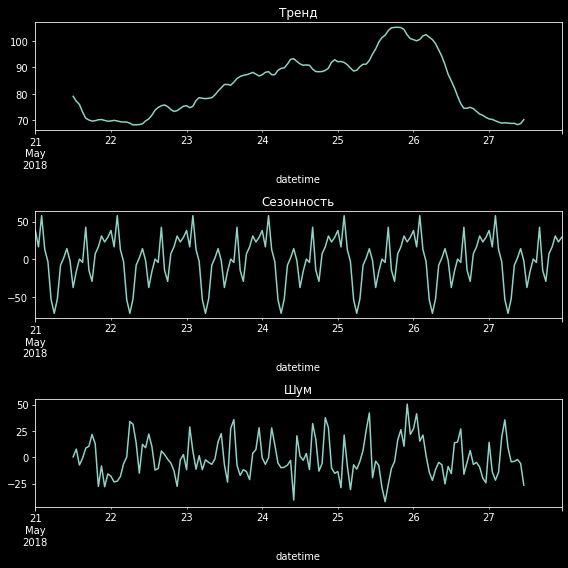

In [11]:
# period within 1 week
taxi_week = taxi_resample['2018-05-21':'2018-05-27']

# function of decomposed data plot
def plot_decompose(decomposed):
    plt.figure(figsize=(8, 8))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Тренд')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Сезонность')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Шум')
    plt.tight_layout()

# decomposed data
decomposed = seasonal_decompose(taxi_week)

# plot of decomposed data
plot_decompose(decomposed)

Тренд связан с днем недели. Количество заказов растет от понедельника к утру субботы, затем наблюдается резкое снижение за выходные. Вероятно, клиенты улетают в отпуска или на выходные, или же, наоборот направляются домой после рабочих поездок.

Сезонность, в общем случае, подтверждает наши выводы при анализе заказов за день.

Построим такие же графики для анализа заказов за весь период. Выполним ресемплирование интервала временного ряда по одному дню.

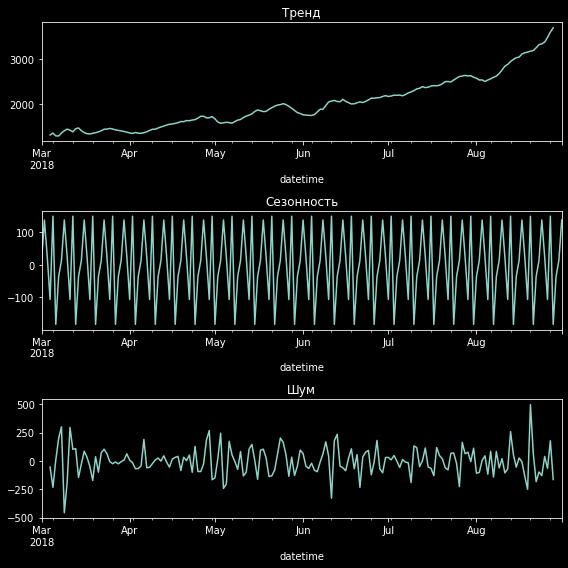

In [12]:
# decomposed data within 1 day
decomposed_all = seasonal_decompose(taxi.resample('1D').sum())

# plot of decomposed data
plot_decompose(decomposed_all)

Тренд указывает на рост заказов от начала месяца к концу. Мы также видим общий тренд - увеличение поездок в такси с каждым месяцем. Вероятно, это связано с летним периодом отпусков. Пик в конце августа указывает на массовое возвращение пассажиров домой. Статистика показывает значительное увеличение поездок (более чем в 3 раза) с марта по август. Сезонность, в общем случае, подтверждает наши выводы при анализе заказов за неделю.

Возьмем интервал в 1 месяц и построим графики.

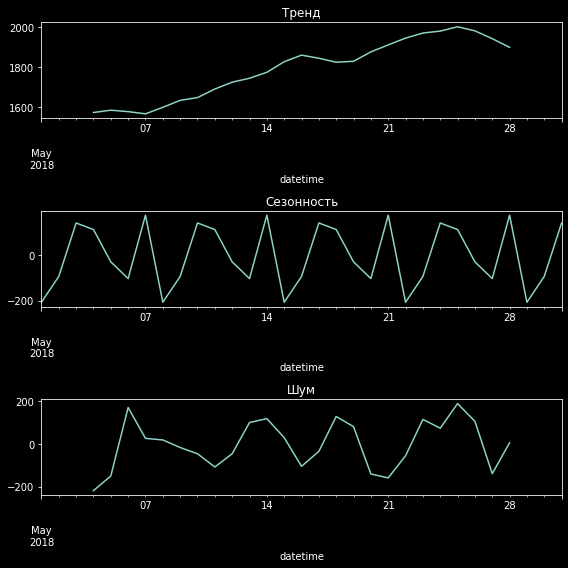

In [13]:
# decomposed data within 1 month
decomposed_month = seasonal_decompose(taxi['2018-05-01':'2018-05-31'].resample('1D').sum())

# plot of decomposed data
plot_decompose(decomposed_month)

Тренд указывает на рост заказов от начала месяца к концу. Сезонность характерна для интервала 1 неделя.

### Стационарность ряда

Прогнозировать данные помогают стационарные ряды. Найдём скользящее стандартное отклонение для данных — стандартное отклонение по скользящему окну. Построим график для него.

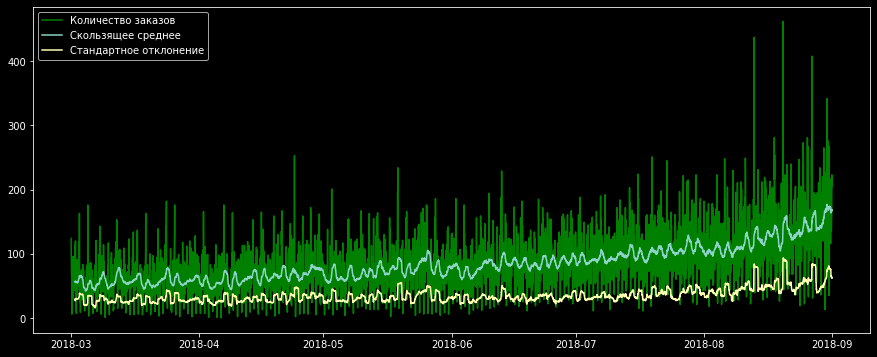

In [14]:
# plot of rolling mean
plot_roll(taxi_resample)

# plot of standard deviation
plt.plot(taxi_resample.rolling(24).std(), label='Стандартное отклонение')
plt.legend();

Стандартное отклонение со временем растет вместе со средним значением. Проверить ряд на стационарность поможет разность его значений. Вычислим эту разность и построим график.

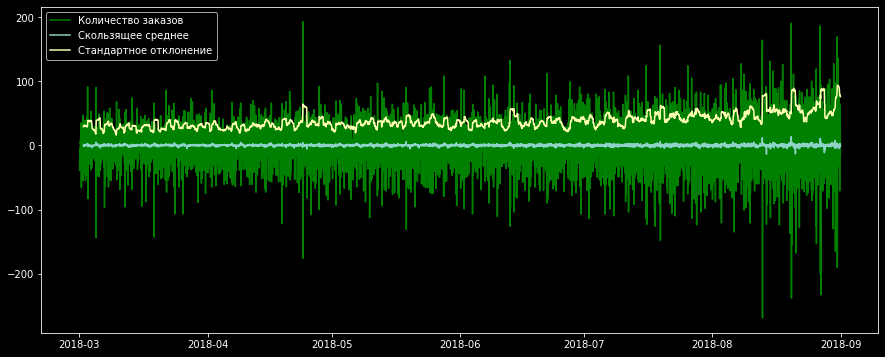

In [15]:
# time series difference 
taxi_diff = taxi_resample - taxi_resample.shift()

# plot of rolling mean
plot_roll(taxi_diff)

# plot of standard deviation
plt.plot(taxi_diff.rolling(24).std(), label='Стандартное отклонение')
plt.legend();

Среднее значение почти не меняется - ряд стал более стационарным, это дает нам возможность его спрогнозировать.

### Вывод

Количество заказов, в общем случае, зависит от часа, дня недели и месяца.

Пик заказов наблюдается ближе к полуночи до часа ночи. Потом происходит резкое падение до 6 утра. Значительное увеличение заказов наблюдается после 6 утра. Остальные заказы в течение дня колеблются около определенной величины.

Тренд связан с днем недели. Количество заказов растет от понедельника к утру субботы, затем наблюдается резкое снижение за выходные. Мы видим общий тренд - увеличение поездок в такси с каждым месяцем. Статистика показывает значительное увеличение заказов (более чем в 3 раза) с марта по август.

Была выполнена проверка ряда на стационарность. Вычисление разности его значений показало, что Скользящее среднее почти не меняется. Ряд стал более стационарным, это дает нам возможность его спрогнозировать.

## Обучение

Задача прогнозирования временного ряда состоит в построении модели,
которая по историческим данным предскажет будущие значения
временного ряда.

### Создание признаков

Напишем функцию, которая создаст новые признаки на базе исходных данных.
1. Календарные признаки `data['day'],..`. В данных тренды и сезонность привязаны к конкретной дате. Тип datetime64 уже содержит нужную информацию, осталось лишь представить её как отдельные столбцы: день, день недели, месяц.
2. Отстающие значения `data['lag_1'],..`. Предыдущие значения временного ряда подскажут, будет ли число заказов расти или уменьшаться. Получим отстающие значения функцией shift(). Выберем его, как 24 ч, целый день в соответствии с сезонностью.
3. Скользящее среднее `data['rolling_mean']`. Скользящее среднее как признак задаёт общий тренд  временного ряда. Вычисление не должно включать в себя текущее значение ряда, чтобы избежать утечки целевого признака. Скользящую средню лучше брать ближе к суткам.

In [16]:
# function of new features creating

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

# create new features
make_features(taxi_resample, 24, 24)


In [17]:
taxi_resample

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


Добавление новых признаков выполнено корректно. Уберем из данных пропущенные значения для корректного обучения модели.

In [18]:
# remove NaN from data
taxi_resample = taxi_resample.dropna()

# quantity of NaN
print('Количество пропусков:', taxi_resample.isna().mean().sum())

Количество пропусков: 0.0


### Определение выборок и метрики

Все столбцы, кроме `num_orders` в наших выборках будем называть - признаки. Признак, который нужно предсказать, — целевой: в нашей задаче это колонка `num_orders`.

Тестовой выборки нет. Значит, данные нужно разбить на две части: обучающую и тестовую.  Сделаем тестовую выборку размером 10% от исходных данных. Зафиксируем псевдослучайность для алгоритма обучения, укажем параметр random_state. 

In [19]:
# train and test sets for data
X_train, X_test, y_train, y_test = train_test_split(taxi_resample.drop('num_orders', axis=1), taxi_resample['num_orders'],
                                                    shuffle=False, test_size=0.1, random_state=123)

Создадим функцию для оценки качества предсказаний, которая будет считать метрику RMSE.

In [20]:
# function of RMSE
def rmse(y_true, predict):
    return mean_squared_error(y_true, predict) ** 0.5

### Линейная регрессия

Обучим линейную регрессию с учётом новых признаков. Вычислим RMSE для предсказаний на обучающей выборке.

In [21]:
# model
model_LR = LinearRegression() 

# model fit
model_LR.fit(X_train, y_train)

# predictions of model
pred_train_LR = model_LR.predict(X_train)

# RMSE
print('RMSE:', rmse(y_train, pred_train_LR))

RMSE: 25.824713299765506


### LightGBM

Рассмотрим модель регрессии LightGBM. Обучим модель и оценим качество кросс-валидацией на "скользящем окне", вызвав TimeSeriesSplit, т.к. нельзя перемешивать в фолдах значения всего ряда без сохранения этой структуры. Нам важно сохранить все взаимосвязи наблюдений друг с другом. Применим метод GridSearchCV, который выберет лучшие гиперпараметры для модели по заданной метрике MSE. Посчитаем RMSE после обучения модели.

In [22]:
# cross-validation for time series
tscv = TimeSeriesSplit(n_splits=5)

# model
model_LGBM = LGBMRegressor()

# model parameters
params_LGBM = {'num_leaves': [31, 100, 200],
          'max_depth': [-1, -2],
          'learning_rate': [0.05, 0.1, 0.2],
          'random_state': [123]}
          
# GridSearchCV
grid_LGBM = GridSearchCV(cv=tscv, estimator=model_LGBM, param_grid = params_LGBM, scoring='neg_mean_squared_error')

In [23]:
%%time

# model RFR fit for train
grid_LGBM.fit(X_train, y_train)

CPU times: user 1min 32s, sys: 1.88 s, total: 1min 34s
Wall time: 1min


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [-1, -2], 'num_leaves': [31, 100, 200],
                         'random_state': [123]},
             scoring='neg_mean_squared_error')

In [24]:
# model best parameters
best_param_LGBM = grid_LGBM.best_params_

print('Гиперпараметры:', best_param_LGBM)
print('RMSE:', abs(grid_LGBM.best_score_)**.5)

Гиперпараметры: {'learning_rate': 0.05, 'max_depth': -1, 'num_leaves': 200, 'random_state': 123}
RMSE: 26.018846792466448


### CatBoost

Рассмотрим модель регрессии CatBoost. Также обучим модель и оценим качество кросс-валидацией на "скользящем окне", вызвав TimeSeriesSplit. Применим метод GridSearchCV, который выберет лучшие гиперпараметры для модели по заданной метрике MSE. Посчитаем RMSE после обучения модели.

In [25]:
# model
model_CB = CatBoostRegressor(verbose=0)

# model parameters
params_CB = {'depth': range(4, 6),
             'learning_rate': [0.1, 0.05],
          'random_state': [123]}

# GridSearchCV
grid_CB = GridSearchCV(cv=tscv, estimator=model_CB, param_grid = params_CB, scoring='neg_mean_squared_error')

In [26]:
%%time

# model RFR fit for train
grid_CB.fit(X_train, y_train)

CPU times: user 1min 50s, sys: 8.41 s, total: 1min 58s
Wall time: 1min 14s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f444b927410>,
             param_grid={'depth': range(4, 6), 'learning_rate': [0.1, 0.05],
                         'random_state': [123]},
             scoring='neg_mean_squared_error')

In [27]:
# model best parameters
best_param_CB = grid_CB.best_params_

print('Гиперпараметры:', best_param_CB)
print('RMSE:', abs(grid_CB.best_score_)**.5)

Гиперпараметры: {'depth': 5, 'learning_rate': 0.05, 'random_state': 123}
RMSE: 25.26039616423156


### Вывод

Были добавлены новые признаки в данные:
* Календарные признаки;
* Отстающие значения;
* Скользящее среднее.

Выполненная обработка данных необходима для более точного обучения модели.

Мы получили следующие результаты для обученных моделей:
* Линейная регрессия. RMSE = 25.82.
* Catboost. RMSE = 25.26.
* LightGBM. RMSE = 26.02.

Предсказания модели Catboost наиболее точные на кросс-валидации по метрике RMSE.

## Тестирование

Обучим модели с лучшими гиперпараметрами на всей тренировочной выборке и оценим качество их предсказаний на тесте по метрике RMSE. Построим графики для целевого признака и его прогноза.

### Линейная регрессия

In [ ]:
%%time

# predictions of model
pred_test_LR = model_LR.predict(X_test)

# RMSE
rmse_LR = rmse(y_test, pred_test_LR)
print('RMSE на тесте:', rmse_LR)


RMSE на тесте: 45.54244745506212
CPU times: user 10.2 ms, sys: 189 µs, total: 10.4 ms
Wall time: 3.15 ms


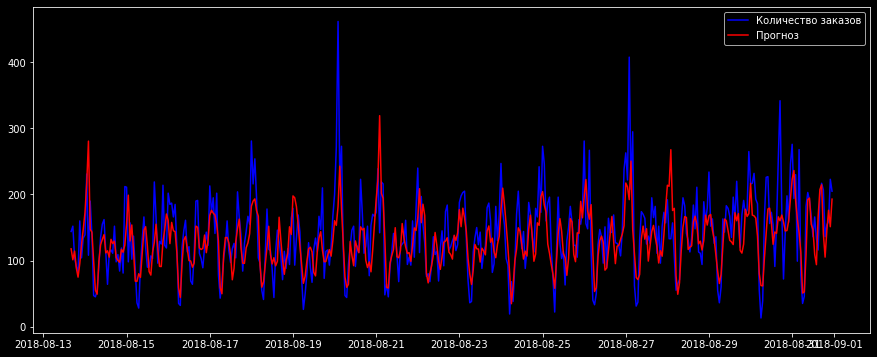

In [ ]:
# plot of target and predict
plt.figure(figsize=figsize)
plt.plot(y_test.index, 
         y_test, 
         'b-', label='Количество заказов')

plt.plot(y_test.index, 
         pred_test_LR,
         'r-', label='Прогноз')

plt.legend();

### LightGBM

In [ ]:
%%time

# set the best parameters
model_LGBM.set_params(**best_param_LGBM)

# model fit
model_LGBM.fit(X_train, y_train)

# predictions of model
pred_test_LGBM = model_LGBM.predict(X_test)

# RMSE
rmse_LGBM = rmse(y_test, pred_test_LGBM)
print('RMSE на тесте:', rmse_LGBM)

RMSE на тесте: 43.00956258092782
CPU times: user 6.32 s, sys: 24.4 ms, total: 6.35 s
Wall time: 6.37 s


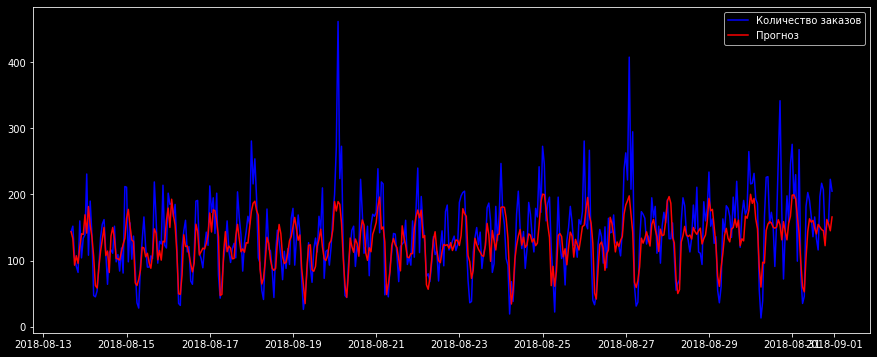

In [ ]:
# plot of target and predict
plt.figure(figsize=figsize)
plt.plot(y_test.index, 
         y_test, 
         'b-', label='Количество заказов')

plt.plot(y_test.index, 
         pred_test_LGBM,
         'r-', label='Прогноз')

plt.legend();

### CatBoost

In [ ]:
# set the best parameters
model_CB.set_params(**best_param_CB)

In [ ]:
%%time

# model fit
model_CB.fit(X_train, y_train)

# predictions of model
pred_test_CB = model_CB.predict(X_test)

# RMSE
rmse_CB = rmse(y_test, pred_test_CB)
print('RMSE на тесте:', rmse_CB)

0:	learn: 37.8096310	total: 4.2ms	remaining: 4.19s
100:	learn: 23.3230743	total: 355ms	remaining: 3.16s
200:	learn: 21.4585297	total: 691ms	remaining: 2.75s
300:	learn: 19.7651087	total: 1.04s	remaining: 2.41s
400:	learn: 18.4125071	total: 1.38s	remaining: 2.06s
500:	learn: 17.2952371	total: 1.72s	remaining: 1.72s
600:	learn: 16.2928996	total: 2.06s	remaining: 1.37s
700:	learn: 15.4344113	total: 2.41s	remaining: 1.03s
800:	learn: 14.6833281	total: 2.76s	remaining: 685ms
900:	learn: 14.0754798	total: 3.12s	remaining: 343ms
999:	learn: 13.5222164	total: 3.46s	remaining: 0us
RMSE на тесте: 41.68028100998033
CPU times: user 3.55 s, sys: 71.2 ms, total: 3.62 s
Wall time: 4.37 s


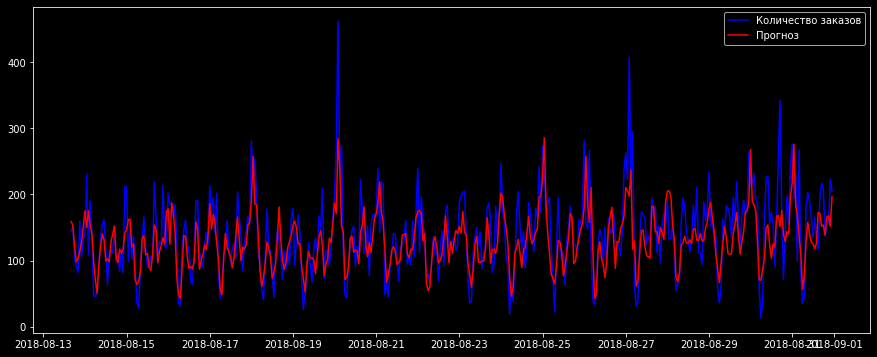

In [ ]:
# plot of target and predict
plt.figure(figsize=figsize)
plt.plot(y_test.index, 
         y_test, 
         'b-', label='Количество заказов')

plt.plot(y_test.index, 
         pred_test_CB,
         'r-', label='Прогноз')

plt.legend();

### Вывод

Было проведено тестирование. Модель, обученная методом CatBoostRegressor, делает предсказания с наибольшей точностью по метрике RMSE.

## Вывод

В нашем распоряжении был архив: исторические данные о заказах такси в аэропортах. Имеется 26496 записей с марта по август 2018 года, интервал записей - 10 минут. Была выполнена подготовка данных:

* Открыли данные, приняв дату за индекс (тип данных Datetime).
* Проверка на монотонность. Даты и время расположены в хронологическом порядке.
* Выполнено ресемплирование по одному часу.

Количество заказов, в общем случае, зависит от часа, дня недели и месяца. Пик заказов наблюдается ближе к полуночи до часа ночи. Потом происходит резкое падение до 6 утра. Значительное увеличение заказов наблюдается после 6 утра. Остальные заказы в течение дня колеблются около определенной величины. Тренд связан с днем недели. Количество заказов растет от понедельника к утру субботы, затем наблюдается резкое снижение за выходные. Мы видим общий тренд - увеличение поездок в такси с каждым месяцем. Статистика показывает значительное увеличение заказов (более чем в 3 раза) с марта по август.

Была выполнена проверка ряда на стационарность. Вычисление разности его значений показало, что Скользящее среднее почти не меняется. Ряд стал более стационарным, это дало нам возможность его спрогнозировать.

Были добавлены новые признаки в данные. Выполненная обработка данных была необходима для более точного обучения модели.

Предсказания модели Catboost наиболее точные на кросс-валидации и на итоговом тесте по метрике RMSE. Все рассматриваемые модели показали требуемое качество предсказаний (RMSE меньше 48) и высокую скорость работы. Сделаем сводную таблицу по результатам исследования.

In [ ]:
pd.DataFrame({'модель':['Catboost', 'LGBM', 'Линейная регрессия'],
              'RMSE':[rmse_CB, rmse_LGBM, rmse_LR],
              'скорость':[ 'высокая', 'высокая', 'высокая']})

,модель,RMSE,скорость
0,Catboost,41.680281,высокая
1,LGBM,43.009563,высокая
2,Линейная регрессия,45.542447,высокая
